In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
from matplotlib import rcParams

Epoch 541/2000:  27%|██▋       | 540/2000 [00:50<01:43, 14.16it/s, v_num=1, elbo_train=1.76e+7]

# Load spatial data

In [ ]:
# File path
file_path = "../../Database/Ravi_Cancer_Cell_2022/10XVisium_2/#"
folders = ['UKF260_T_ST']

run_name = f'{file_path}{folders[0]}/outs/spatial/cell2location_map'

In [ ]:
# Load the json file for spatial scale factors
with open(file_path + folders[0] + '/outs/spatial/scalefactors_json.json', 'r') as file:
    scale_factors = json.load(file)

scale_factors

In [ ]:
# Load stRNA-seq data
adata_vis = sc.read_10x_h5(file_path + folders[0] + "/outs/filtered_feature_bc_matrix.h5")
adata_vis.obs['sample'] = 'UKF260_T_ST'
adata_vis.var_names_make_unique()

# 이미지를 Numpy 배열로 변환
hires_image = Image.open(file_path + folders[0] + '/outs/spatial/tissue_hires_image.png')
lowres_image = Image.open(file_path + folders[0] + '/outs/spatial/tissue_lowres_image.png')

adata_vis.uns['spatial'] = {
    folders[0]: {
        'scalefactors': scale_factors,
        'images': {
            'hires': np.array(hires_image),
            'lowres': np.array(lowres_image)
        },
        'type': 'visium'
    }
}

In [ ]:
# Load the spot data
spot_data = pd.read_csv(file_path + folders[0] +'/outs/spatial/tissue_positions_list.csv', header = None)
spot_data.columns = ['barcode', 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres']

# 기존 anndata의 obs에서 spot_id를 가져와 위치 정보 추가
spot_ids = spot_data.set_index('barcode')
adata_vis.obs = adata_vis.obs.join(spot_ids[['pxl_col_in_fullres', 'pxl_row_in_fullres']], how='left')
adata_vis.obsm['spatial'] = adata_vis.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].values

In [ ]:
# Plot images
rcParams['figure.figsize'] = 6, 6

# 특정 유전자의 공간 발현 시각화
sc.pl.spatial(adata_vis, color=['MAP2', 'MBP'], img_key = 'lowres', alpha_img = 1, alpha = 1, cmap = 'rainbow')
sc.pl.spatial(adata_vis, color=['NLGN3', 'BHLHE40'], img_key = 'lowres', alpha_img = 1, alpha = 1, cmap = 'rainbow')
sc.pl.spatial(adata_vis, color=['OLIG2', 'GFAP'], img_key = 'lowres', alpha_img = 1, alpha = 1, cmap = 'rainbow')


---

# Modify the spatial data with sc_ref

In [ ]:
adata_vis.var['SYMBOL'] = adata_vis.var_names   # save var_names to 'SYMBOL'
adata_vis.var.set_index('gene_ids', drop = True, inplace = True)    # set ENSEMBL ID as index

In [ ]:
# sc.pl.spatial(adata, color=['OLIG2', 'GFAP'], img_key = 'lowres', alpha_img = 1, alpha = 1, cmap = 'rainbow', gene_symbols='SYMBOL')

In [ ]:
# remove mitochondrial genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [ ]:
adata_vis

# Train the model

In [1]:
import cell2location

/home/jsw/jswenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-06 10:35:32.534846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 10:35:32.565488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 10:35:32.575303: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 10:35:33.212539: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find

In [4]:
print(cell2location.__version__)

0.1.4


In [ ]:
inf_aver = pd.read_csv('../data/inf_aver.csv', index_col = 0)

intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
# intersect.shape

adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [ ]:
# Prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(
    adata = adata_vis,
    batch_key = 'sample'
)

In [ ]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis,
    cell_state_df = inf_aver,
    N_cells_per_location = 30,
    detection_alpha = 20
)

In [ ]:
mod.view_anndata_setup()

In [ ]:
mod.train(max_epochs=2000, batch_size = None, train_size = 1)

In [ ]:
mod.plot_history(20)
plt.legend(labels = ['full data training'])

In [ ]:
# Export the estimated cell abundance
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

# Save model
mod.save(f"{run_name}", overwrite = True)

# load model
# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

---
# Load by this

In [20]:
adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

INFO     File ../../Database/Ravi_Cancer_Cell_2022/10XVisium_2/#UKF260_T_ST/outs/spatial/cell2location_map/model.pt
         already downloaded                                                                                        


/home/jsw/jswenv/lib/python3.10/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=map

Epoch 1/30000:   0%|          | 1/30000 [00:00<32:51, 15.22it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/30000:   0%|          | 1/30000 [00:00<33:53, 14.75it/s, v_num=1]


---

In [21]:
mod.plot_QC()

RuntimeError: self.samples is missing, please run self.export_posterior() first

Epoch 541/2000:  27%|██▋       | 540/2000 [01:44<04:42,  5.17it/s, v_num=1, elbo_train=1.76e+7]


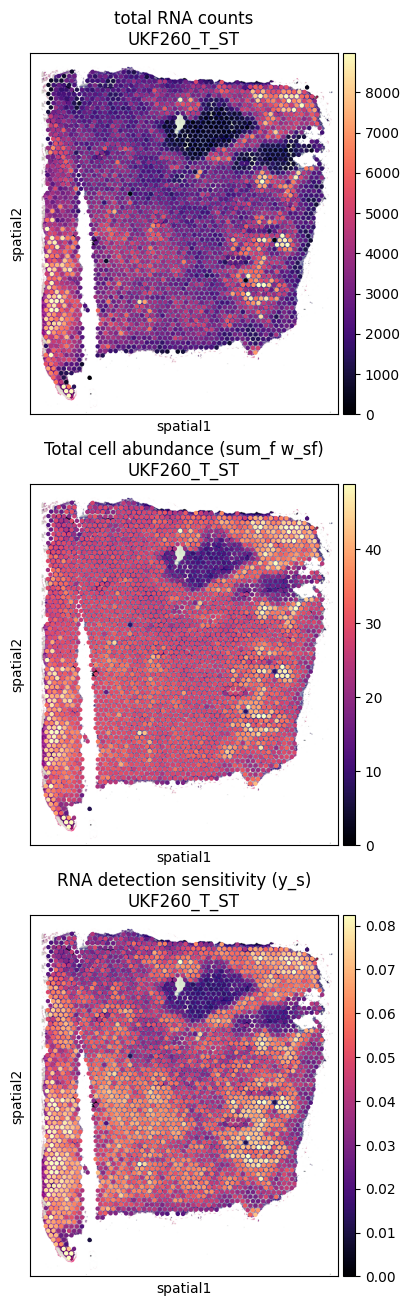

In [22]:
fig = mod.plot_spatial_QC_across_batches()

In [23]:
adata_vis

AnnData object with n_obs × n_vars = 2997 × 11230
    obs: 'sample', 'pxl_col_in_fullres', 'pxl_row_in_fullres', '_indices', '_scvi_batch', '_scvi_labels', 'total RNA counts', 'Total cell abundance (sum_f w_sf)', 'RNA detection sensitivity (y_s)'
    var: 'feature_types', 'genome', 'SYMBOL', 'MT_gene'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod', 'spatial'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [24]:
import matplotlib as mpl
from cell2location.utils import select_slide

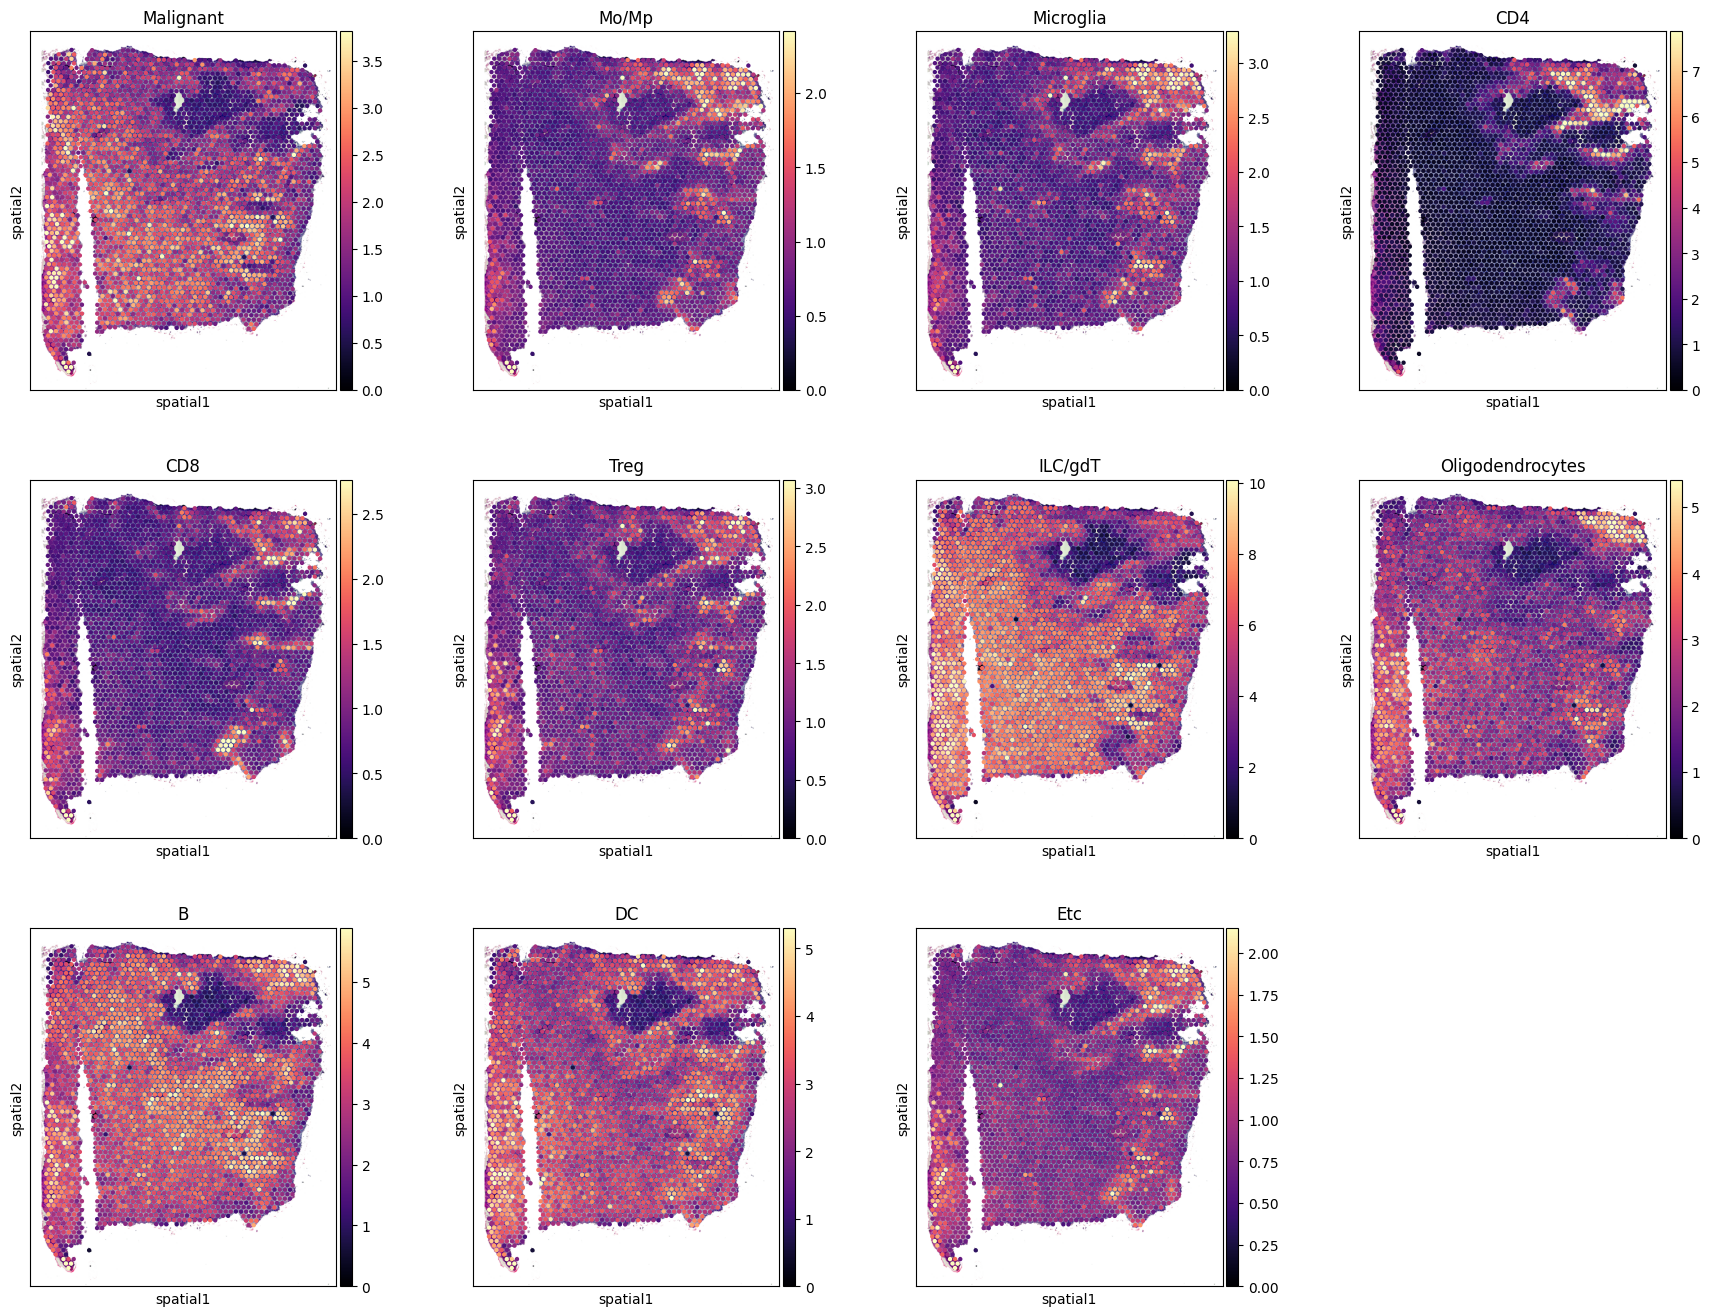

In [43]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
slide = select_slide(adata_vis, 'UKF260_T_ST')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  color=['Malignant','Mo/Mp','Microglia','CD4','CD8','Treg','ILC/gdT','Oligodendrocytes','B','DC','Etc'],
                # color = ['Mo/Mp', 'Microglia'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

In [34]:
clust_col

['Mo/Mp', 'Microglia']

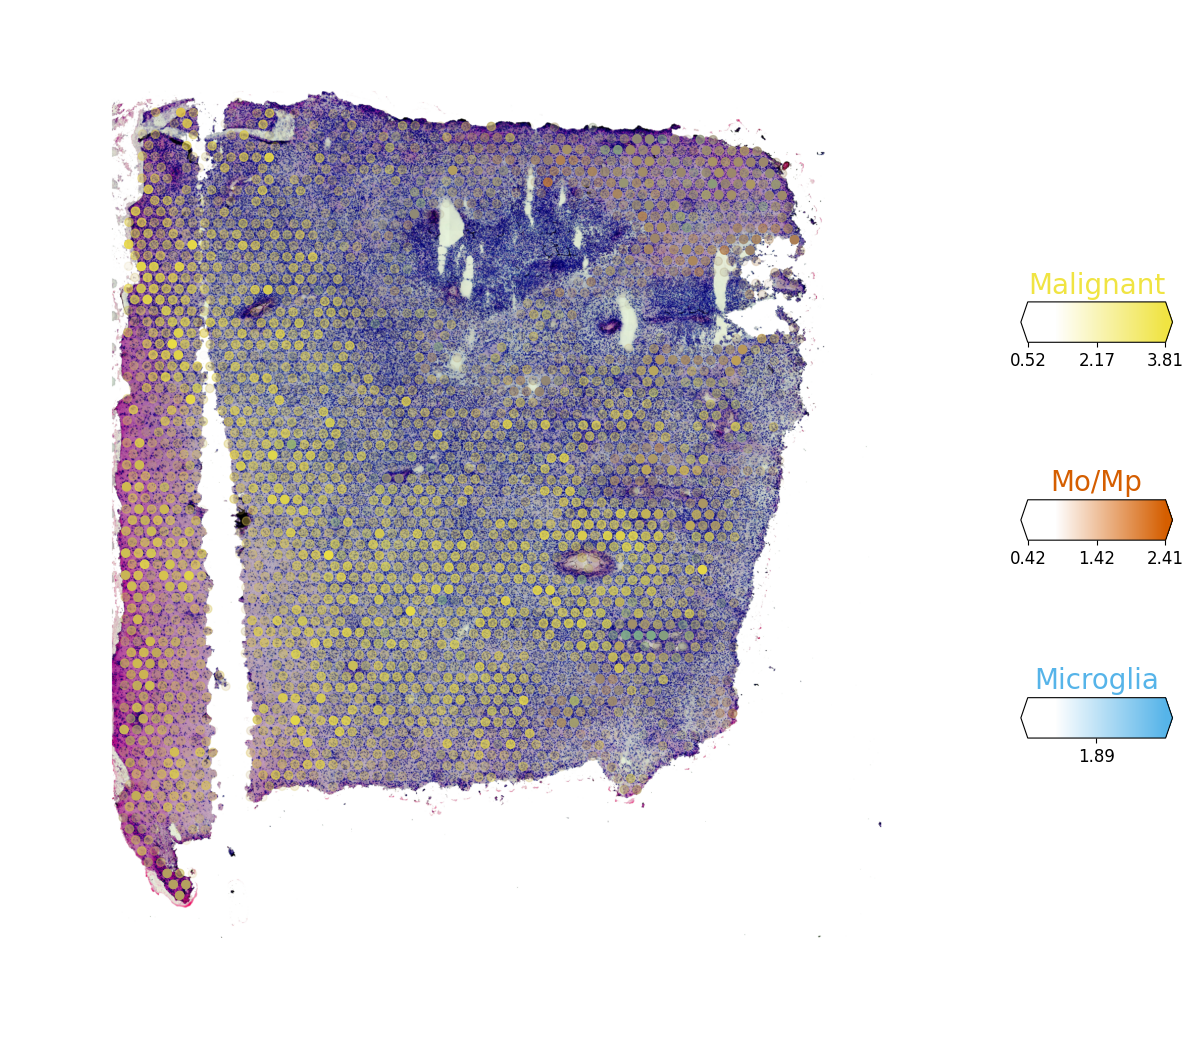

In [42]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['Malignant', 'Mo/Mp', 'Microglia']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata_vis, 'UKF260_T_ST')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right',
        # change color
        
    )

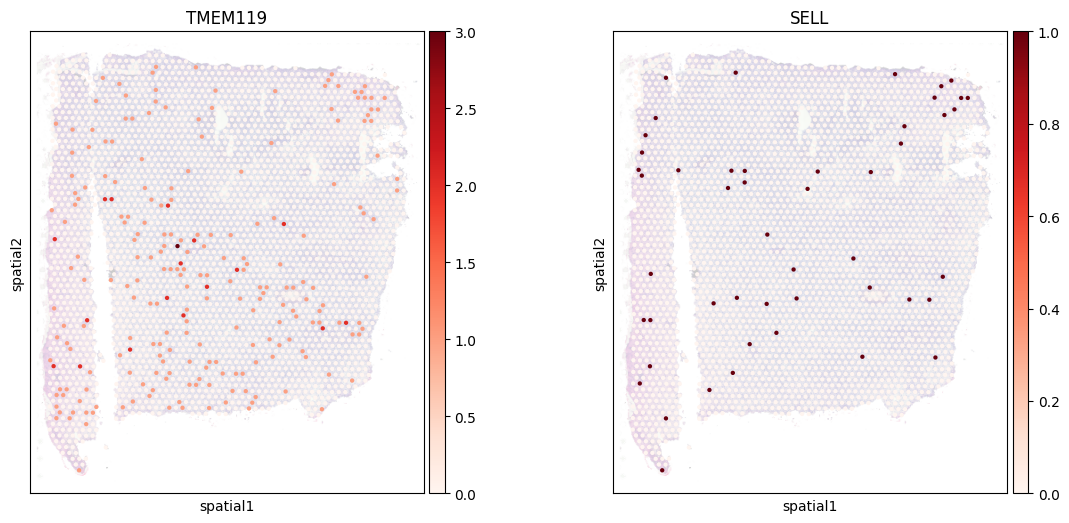

In [27]:
sc.pl.spatial(adata_vis, color = ["TMEM119", 'SELL'], gene_symbols="SYMBOL", img_key = 'lowres', alpha_img = 0.2, cmap = 'Reds')